# Testes com [Dask](https://dask.org/) em Python

Python é uma linguagem que une diferentes ferramentas para a ciência de dados, Dask é uma biblioteca em python para auxiliar a análise de grandes volumes de dados.

A programação paralela significa dividir o problema em partes separadas e unir as partes no final do processamento, Dask possui a escalabilidade existente no ecossistema python.

Os dados são divididos em chunks que podem ser manipulados indenpendentemente em paralelo.

In [221]:
from dask.distributed import Client
client = Client(n_workers = 4)

In [222]:
def fibonacci(n):
    if n < 3:
        return 1
    else:
        return fibonacci(n - 2) + fibonacci(n - 1)

In [223]:
from dask import delayed
from time import sleep
import time
import pandas as pd

In [224]:
%%time
# Serial

x = fibonacci(10)
y = fibonacci(20)
z = fibonacci(30)
soma = sum([x, y, z])

CPU times: user 145 ms, sys: 12.1 ms, total: 157 ms
Wall time: 148 ms


In [225]:
%%time
soma

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


838860

In [226]:
%%time
# Paralelo, construção de um gráfico

x = delayed(fibonacci)(10)
y = delayed(fibonacci)(20)
z = delayed(fibonacci)(30)
soma = delayed(sum)([x,y,z])

CPU times: user 1.33 ms, sys: 0 ns, total: 1.33 ms
Wall time: 937 µs


In [227]:
%%time
# União dos dados partidos
soma.compute()

CPU times: user 35.8 ms, sys: 3.58 ms, total: 39.4 ms
Wall time: 167 ms


838860

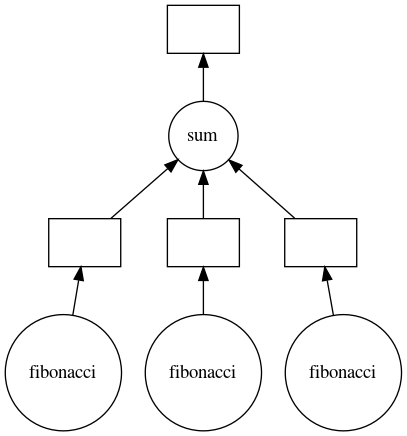

In [228]:
# Visulização dos processos partidos
soma.visualize()

## [Lei de Amdahl](https://pt.wikipedia.org/wiki/Lei_de_Amdahl)

   A lei de Amdahl, também conhecida como argumento de Amdahl, é usada para encontrar a máxima melhora esperada para um sistema em geral quando apenas uma única parte do mesmo é melhorada. Isto é frequentemente usado em computação paralela para prever o máximo speedup teórico usando múltiplos processadores.
  O speedup de um programa usando múltiplos processadores em computação paralela é limitado pelo tempo necessário para a fração sequencial de um programa. Por exemplo, se o programa precisa de 20 horas usando um único núcleo de processamento, e a parte específica de um programa que demora uma hora para executar não pode ser paralelizado, enquanto as 19 horas restantes (95%) do tempo da execução pode ser paralelizado, independente de quantos processadores são dedicados a execução paralela deste programa, o tempo de execução mínima não pode ser menor que aquela crítica uma hora. Por isso o aumento de velocidade é limitado em no máximo 20x.

In [229]:
# Criando um processo para o álculo do número de Amdahl
soma.compute()
exptimes = []

for cores in [1,2,4,8]: # Número de cores para a análise
    for trials in range(20):
        inicio = time.perf_counter()
        soma.compute(num_workers = cores)
        tempo = time.perf_counter() - inicio
        exptimes.append([cores, tempo])
        
df = pd.DataFrame(exptimes, columns = ["cores","time"])
df

,cores,time
0,1,0.003677
1,1,0.172172
2,1,0.175682
3,1,0.178415
4,1,0.003606
...,...,...
75,8,0.170765
76,8,0.168268
77,8,0.157795
78,8,0.158130


In [230]:
df.groupby('cores').describe()

time                                                              \
      count      mean       std       min       25%       50%       75%   
cores                                                                     
1      20.0  0.149151  0.063284  0.003606  0.165578  0.171997  0.179430   
2      20.0  0.161940  0.123058  0.002486  0.163471  0.170900  0.183505   
4      20.0  0.152014  0.051039  0.002852  0.165215  0.168168  0.170890   
8      20.0  0.141762  0.059454  0.004268  0.157455  0.166087  0.170858   

                 
            max  
cores            
1      0.194227  
2      0.589032  
4      0.174882  
8      0.174169

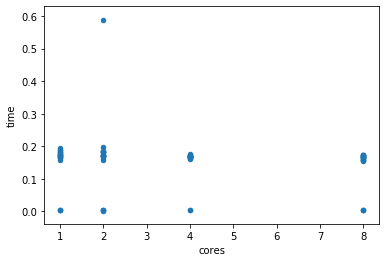

In [231]:
%matplotlib inline
df.plot(x = 'cores', y = 'time', kind = 'scatter')

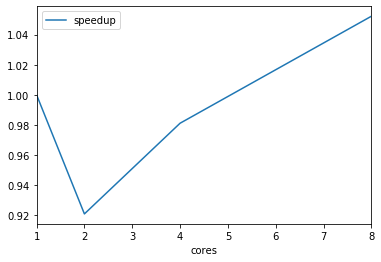

In [232]:
# Cálculo do Speedup de um processo
media = df.groupby('cores').mean()
media['speedup'] = media.loc[1].time / media['time']
media.plot(y = 'speedup', kind = 'line')

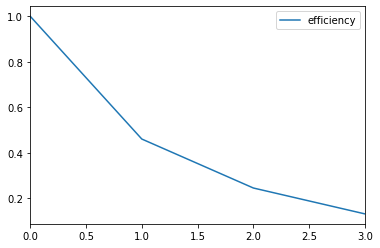

In [233]:
media.reset_index(inplace = True)
media['efficiency'] = media.loc[0].time / media['time'] / media['cores']
media.plot(y = ['efficiency'], kind = 'line');
# Essa linha é importante para a conversão em dados legíveis
df.reset_index(inplace = True)

In [234]:
media['amdahls_number'] = (media.cores/(media.cores-1)) * (1-1/media.speedup)
# Calculando o número de Amdahl
media

,cores,time,speedup,efficiency,amdahls_number
0,1,0.149151,1.000000,1.000000,NaN
1,2,0.161940,0.921027,0.460513,-0.171490
2,4,0.152014,0.981169,0.245292,-0.025590
3,8,0.141762,1.052127,0.131516,0.056623


## Teste um pouco mais complexo

![this](https://upload.wikimedia.org/wikipedia/commons/e/ee/Binomial_tree.gif)

In [235]:
# Redução
def partition(lista):
    result = []
    if len(lista) % 2 == 0:
        i, lenght = 0, 2
        while lenght <= len(lista):
            result.append(lista[i:lenght])
            i, lenght = i + 2, lenght + 2
        return result
    else:
        pop = lista.pop()
        result = partition(lista)
        result.append([pop, 0])
        return result

def calculator(lista):
    soma = []
    for par in partition(lista):
        soma.append(int(par[0]) + int(par[1]))
    return soma        

def reduction(lista):
    if len(lista) == 1:
        return lista[0]
    else:
        aux = lista
        while len(aux) != 1:
            aux = calculator(aux)
        return aux[0]

In [236]:
%%time
lista = [2,3,5,1,7,6,8,4]
result = reduction(lista)

CPU times: user 16 µs, sys: 0 ns, total: 16 µs
Wall time: 20 µs


In [237]:
%%time
result

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 12.6 µs


36

In [238]:
# Redução
def partition(lista):
    result = []
    if len(lista) % 2 == 0:
        i, lenght = 0, 2
        while lenght <= len(lista):
            result.append(lista[i:lenght])
            i, lenght = i + 2, lenght + 2
        return result
    else:
        pop = lista.pop()
        result = delayed(partition)(lista)
        result = result.compute()
        result.append([pop, 0])
        return result

def calculator(lista):
    soma = []
    var = delayed(partition)(lista)
    for par in var.compute():
        soma.append(int(par[0]) + int(par[1]))
    return soma

def reduction(lista):
    if len(lista) == 1:
        return lista[0]
    else:
        aux = lista
        while len(aux) != 1:
            calc = delayed(calculator)(aux)
            aux = calc.compute()
        return aux[0]

In [239]:
%%time
lista = [2,3,5,1,7,6,8,4]
soma = delayed(reduction)(lista)

CPU times: user 473 µs, sys: 73 µs, total: 546 µs
Wall time: 395 µs


In [240]:
%%time
soma.compute()

CPU times: user 33.6 ms, sys: 11.3 ms, total: 44.9 ms
Wall time: 93.3 ms


36

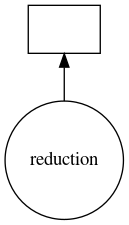

In [241]:
soma.visualize()

In [242]:
client.close()